In [1]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2019-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [2]:
import nxsdk.api.n2a as nx
import matplotlib.pyplot as plt
import numpy as np
from nxsdk.compiler.nxsdkcompiler.n2_compiler_exceptions import NxBoundsValidationError

# Connection Sharing
This tutorial demonstrates how to use the connection sharing feature. In order to reuse connections with the same configurations, NxNet supports the concept of shared connections.  If more than one pair of compartment groups are to be connected with identical connections, instead of independently creating multiple identical sets of connections, it is possible to share one set of connections to connect all pairs of the compartment groups. Due to hardware limitations in sharing connections, there are restrictions on shared connections.  Please refer to the documentation for a complete set of restrictions.

## Network Creation Function
This function takes a network and creates two pairs of compartment groups.  The first pair is connected in the standard way.  The second pair of compartments can either be connected in the standard way, i.e. with a new set of connections, or connected through connection sharing.  

In [3]:
def createBasicNetwork(net, grpSize=5, connSharing=True):
    """Create basic network for testing.  grpSize should be a multiple of 5."""

    assert grpSize % 5 == 0, "In this example, grpSize should be a multiple of 5."

    # Setup compartment prototypes
    prototype1a = nx.CompartmentPrototype(biasMant=1, biasExp=6, vThMant=10,
                                          functionalState=2,
                                          compartmentVoltageDecay=300,
                                          compartmentCurrentDecay=410)

    prototype1b = nx.CompartmentPrototype(biasMant=1, biasExp=6, vThMant=10,
                                          functionalState=2,
                                          compartmentVoltageDecay=320,
                                          compartmentCurrentDecay=410)

    prototype1c = nx.CompartmentPrototype(biasMant=1, biasExp=6, vThMant=10,
                                          functionalState=2,
                                          compartmentVoltageDecay=340,
                                          compartmentCurrentDecay=410)

    prototype1d = nx.CompartmentPrototype(biasMant=1, biasExp=6, vThMant=10,
                                          functionalState=2,
                                          compartmentVoltageDecay=360,
                                          compartmentCurrentDecay=410)

    prototype1e = nx.CompartmentPrototype(biasMant=1, biasExp=6, vThMant=10,
                                          functionalState=2,
                                          compartmentVoltageDecay=380,
                                          compartmentCurrentDecay=410)

    prototype2 = nx.CompartmentPrototype(vThMant=50,
                                         compartmentVoltageDecay=4095,
                                         compartmentCurrentDecay=4095)

    protoList = [prototype1a, prototype1b, prototype1c, prototype1d,
                 prototype1e]
    protoMapBase = np.array([[0, 1, 2, 3, 4]])
    protoMap = np.repeat(protoMapBase, grpSize // 5, axis=0)
    protoMap = protoMap.flatten().tolist()

    # Create first source compartment group
    cg1 = net.createCompartmentGroup(size=grpSize,
                                     prototype=protoList,
                                     prototypeMap=protoMap)
    # Create first destination compartment group
    cg2 = net.createCompartmentGroup(size=grpSize, prototype=prototype2)

    # Create second source compartment group
    cg3 = net.createCompartmentGroup(size=grpSize,
                                     prototype=protoList,
                                     prototypeMap=protoMap)
    # create second destination compartment group
    cg4 = net.createCompartmentGroup(size=grpSize, prototype=prototype2)

    # Setup connection prototype
    connProto = nx.ConnectionPrototype()
    
    # Connect first pair of compartment groups
    conn = cg1.connect(cg2,
                       prototype=connProto,
                       weight=200 * np.identity(grpSize, dtype=int))

    # Connect second pair of compartment groups (with or without connection sharing)
    if connSharing:
        conn = cg3.connect(cg4, sharedConnGrp=conn, synapseSharingOnly=True)
    else:
        conn = cg3.connect(cg4,
                           prototype=connProto,
                           weight=200 * np.identity(grpSize, dtype=int))

    return (net, conn, cg1, cg2, cg3, cg4)

## Create Network Without Connection Sharing
First the network is created without the use of connection sharing.  This means that an additional set of connections are created while connecting the second pair of compartment groups.  Due to the total number of connections required, during execution an error is raised indicating that synaptic resources have been exhausted.

In [4]:
# ---------------------------------------------------------------------
# Build Network
# ---------------------------------------------------------------------
net = nx.NxNet()

grpSize = 225
(net, conn, cg1, cg2, cg3, cg4) = createBasicNetwork(net,
    grpSize=grpSize, connSharing=False)

sProbes = cg2.probe([nx.ProbeParameter.SPIKE])
sProbes2 = cg4.probe([nx.ProbeParameter.SPIKE])

# ---------------------------------------------------------------------
# Run
# ---------------------------------------------------------------------
try:
    net.run(60)
except NxBoundsValidationError as e:
    print(e)
finally:
    net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.36:40053
INFO:DRV:      Host server up..............Done 17.37s
INFO:DRV:      Encoding axons/synapses.....Done 0.08s
INFO:DRV:  Executor: 60 timesteps..........Done 17.45s
Number of synapse mem registers exceeded. Allowed limit is 16384. There are too many synapses on a core. It may be possible to alleviate the problem by (1) using compressionMode=3 (dense), (2) reducing the bit width for weight, delay, and tag, e.g. set it to 0, if some field is not being used, or (3) distributing the network across additional logical cores to reduce the number of synapses on any given logical core.


## Create Network With Connection Sharing
Next, the network is created with the use of connection sharing.  This means that the second pair of compartment groups is connected using the same connections used by the first pair of compartment groups.  Due to the sharing of synapses, the two pairs of compartments are successfully connected.

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.36:38947
INFO:DRV:      Host server up..............Done 7.97s
INFO:DRV:      Encoding axons/synapses.....Done 0.14s
INFO:DRV:      Encoding probes.............Done 1.04ms
INFO:DRV:      Booting up..................Done 10.22s
INFO:DRV:      Transferring probes.........Done 7.25ms
INFO:DRV:      Configuring registers.......Done 0.05s
INFO:DRV:      Transferring spikes.........Done 0.08ms
INFO:DRV:      Executing...................Done 0.08s
INFO:DRV:      Processing timeseries.......Done 0.01s
INFO:DRV:  Executor: 60 timesteps..........Done 18.48s


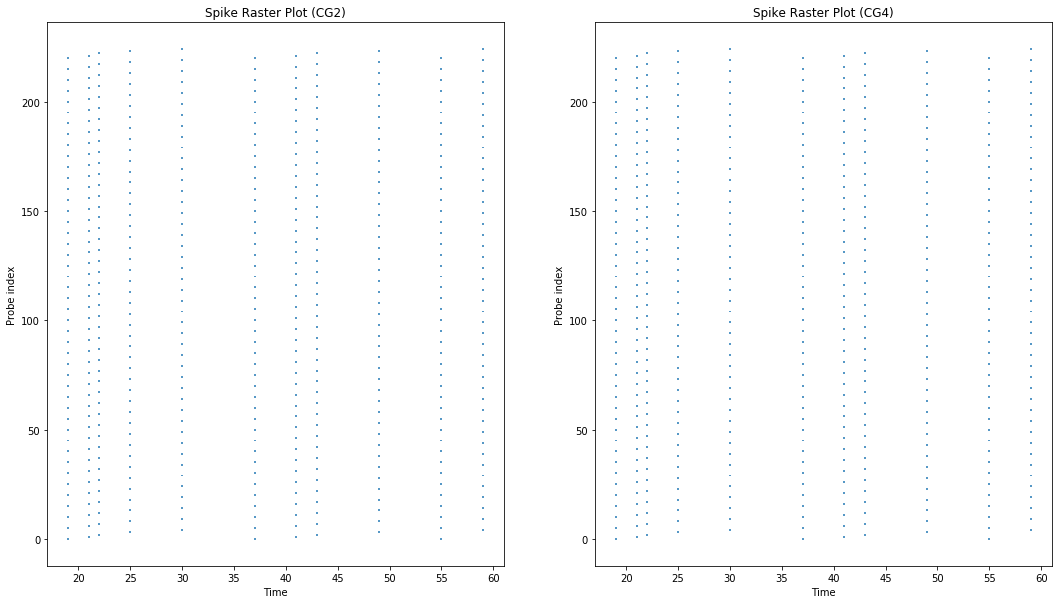

In [5]:
# ---------------------------------------------------------------------
# Build Network
# ---------------------------------------------------------------------
net = nx.NxNet()

grpSize = 225
(net, conn, cg1, cg2, cg3, cg4) = createBasicNetwork(net,
    grpSize=grpSize, connSharing=True)

sProbes = cg2.probe([nx.ProbeParameter.SPIKE])
sProbes2 = cg4.probe([nx.ProbeParameter.SPIKE])

# ---------------------------------------------------------------------
# Run
# ---------------------------------------------------------------------
net.run(60)
net.disconnect()

# ---------------------------------------------------------------------
# Plot
# ---------------------------------------------------------------------
plt.figure(1, figsize=(18,10))
ax0 = plt.subplot(1, 2, 1)
sh = sProbes[0].plot()
plt.title("Spike Raster Plot (CG2)")
ax0 = plt.subplot(1, 2, 2)
sh = sProbes2[0].plot()
plt.title("Spike Raster Plot (CG4)")
plt.show()

.. code-links:: python clear